In [16]:
# Install (Colab) - uncomment if running in Colab and packages are missing
# You can leave these commented in local environments that already have the packages.
# !pip install xgboost==1.7.6 shap --quiet

import os, warnings, math
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
sns.set_theme(style="whitegrid")

RANDOM_STATE = 12345


In [17]:
# Load CSV (tries local path; if not found prompts upload in Colab)
csv_path = 'Assessment 2 - MMM Weekly.csv'
if not os.path.exists(csv_path):
    try:
        from google.colab import files
        uploaded = files.upload()
        csv_path = list(uploaded.keys())[0]
    except Exception as e:
        print('If running locally, ensure the CSV is in the same folder and named exactly:', csv_path)
        raise

df = pd.read_csv(csv_path, parse_dates=['week'])
print('Loaded', csv_path, 'shape=', df.shape)
df.head()

Loaded Assessment 2 - MMM Weekly.csv shape= (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


Columns: ['week', 'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue']

Data types:
 week                datetime64[ns]
facebook_spend             float64
google_spend               float64
tiktok_spend               float64
instagram_spend            float64
snapchat_spend             float64
social_followers             int64
average_price              float64
promotions                   int64
emails_send                  int64
sms_send                     int64
revenue                    float64
dtype: object

Missing values:
 week                0
facebook_spend      0
google_spend        0
tiktok_spend        0
instagram_spend     0
snapchat_spend      0
social_followers    0
average_price       0
promotions          0
emails_send         0
sms_send            0
revenue             0
dtype: int64


,count,mean,min,25%,50%,75%,max,std
week,104,2024-09-11 12:00:00,2023-09-17 00:00:00,2024-03-15 06:00:00,2024-09-11 12:00:00,2025-03-10 18:00:00,2025-09-07 00:00:00,NaN
facebook_spend,104.0,5346.3025,2456.94,4538.9775,5293.78,6033.325,9325.18,1168.961177
google_spend,104.0,1543.866442,0.0,0.0,0.0,3374.205,6083.16,1863.350279
tiktok_spend,104.0,955.632212,0.0,0.0,0.0,2487.1725,4143.25,1376.993132
instagram_spend,104.0,1019.342885,0.0,0.0,0.0,2395.35,3877.99,1349.18425
snapchat_spend,104.0,747.465,0.0,0.0,0.0,1705.8725,3126.04,982.088273
social_followers,104.0,72414.509615,0.0,38318.25,81109.5,110281.25,143477.0,47778.448985
average_price,104.0,99.9625,87.56,94.2075,99.49,105.395,113.38,6.496186
promotions,104.0,0.211538,0.0,0.0,0.0,0.0,1.0,0.410377
emails_send,104.0,120691.067308,68655.0,102971.5,120237.0,136594.0,185460.0,25158.181476


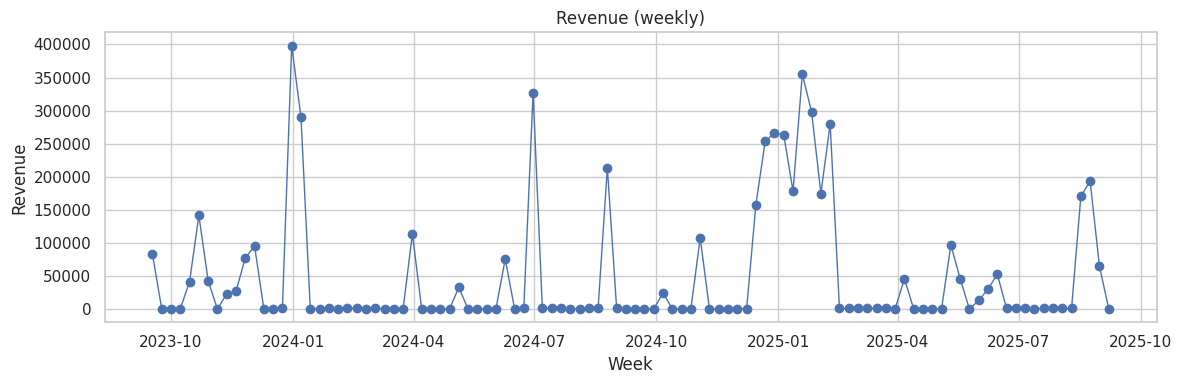

In [18]:
# Basic EDA
print('Columns:', df.columns.tolist())
print('\nData types:\n', df.dtypes)
print('\nMissing values:\n', df.isna().sum())

display(df.describe().T)

# Plot revenue timeseries
df = df.sort_values('week').reset_index(drop=True)
plt.figure(figsize=(12,4))
plt.plot(df['week'], df['revenue'], marker='o', linewidth=1)
plt.title('Revenue (weekly)')
plt.ylabel('Revenue')
plt.xlabel('Week')
plt.tight_layout()

In [19]:
# Preprocessing & Feature Engineering
data = df.copy()

# date features
data['week'] = pd.to_datetime(data['week'])
data = data.sort_values('week').reset_index(drop=True)
data['trend'] = np.arange(len(data))  # simple trend
data['week_of_year'] = data['week'].dt.isocalendar().week.astype(int)

# cyclical encoding for week of year (to capture seasonality)
data['woy_sin'] = np.sin(2*np.pi*data['week_of_year']/52)
data['woy_cos'] = np.cos(2*np.pi*data['week_of_year']/52)

# social combined metric (optional)
social_cols = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend']
for c in social_cols:
    if c not in data.columns:
        data[c] = 0.0

data['social_spend_total'] = data[social_cols].sum(axis=1)

# lags for media (to allow delayed effects)
for c in social_cols + ['google_spend']:
    data[c + '_lag1'] = data[c].shift(1).fillna(0)
    data[c + '_lag2'] = data[c].shift(2).fillna(0)

# rolling 4-week means (short memory)
for c in social_cols + ['google_spend']:
    data[c + '_r4'] = data[c].rolling(window=4, min_periods=1).mean().shift(1).fillna(0)

# zero-spend indicator (to capture zero-activity weeks)
for c in social_cols + ['google_spend']:
    data[c + '_iszero'] = (data[c] == 0).astype(int)

# log transforms - use log1p to handle zeros
data['revenue_log'] = np.log1p(data['revenue'].clip(lower=0))
for c in social_cols + ['google_spend']:
    data[c + '_log1p'] = np.log1p(data[c].clip(lower=0))

# fill other missing numeric features
num_cols = data.select_dtypes(include=np.number).columns.tolist()
data[num_cols] = data[num_cols].fillna(0)

print('Prepared features. Shape:', data.shape)
data.head().T

Prepared features. Shape: (104, 43)


,0,1,2,3,4
week,2023-09-17 00:00:00,2023-09-24 00:00:00,2023-10-01 00:00:00,2023-10-08 00:00:00,2023-10-15 00:00:00
facebook_spend,6030.8,5241.44,5893.0,7167.16,5360.29
google_spend,3130.14,2704.0,0.0,0.0,0.0
tiktok_spend,2993.22,0.0,0.0,0.0,0.0
instagram_spend,1841.08,0.0,0.0,0.0,3237.15
snapchat_spend,2204.72,0.0,0.0,0.0,0.0
social_followers,0,0,0,0,0
average_price,101.95,103.86,100.38,103.14,107.76
promotions,0,0,0,1,1
emails_send,102684,96573,96797,99098,120754


In [20]:
# Train-test split: use last ~20% of weeks as holdout (time-aware)
n = len(data)
test_size = max(12, int(0.20 * n))  # at least ~12 weeks as holdout
train_idx = list(range(0, n - test_size))
test_idx = list(range(n - test_size, n))

train = data.loc[train_idx].reset_index(drop=True)
test = data.loc[test_idx].reset_index(drop=True)

print('Train weeks:', train['week'].min(), 'to', train['week'].max())
print('Test weeks:', test['week'].min(), 'to', test['week'].max())

Train weeks: 2023-09-17 00:00:00 to 2025-04-20 00:00:00
Test weeks: 2025-04-27 00:00:00 to 2025-09-07 00:00:00


In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import numpy as np

# -----------------------------
# Stage 1: predict google_spend (mediator)
# -----------------------------
stage1_features = [
    'facebook_spend', 'facebook_spend_lag1', 'facebook_spend_r4',
    'tiktok_spend', 'tiktok_spend_lag1', 'tiktok_spend_r4',
    'instagram_spend', 'instagram_spend_lag1', 'instagram_spend_r4',
    'snapchat_spend', 'snapchat_spend_lag1', 'snapchat_spend_r4',
    'social_followers', 'promotions', 'emails_send', 'sms_send',
    'trend', 'woy_sin', 'woy_cos'
]

X1_train = train[stage1_features]
y1_train = train['google_spend']
X1_test = test[stage1_features]
y1_test = test['google_spend']

tscv = TimeSeriesSplit(n_splits=5)
pipe1 = Pipeline([
    ('scale', StandardScaler()),
    ('en', ElasticNetCV(cv=tscv, random_state=RANDOM_STATE))
])

pipe1.fit(X1_train, y1_train)
print('Stage1 chosen alpha:', pipe1.named_steps['en'].alpha_)

# Predictions
y1_pred_train = pipe1.predict(X1_train)
y1_pred_test = pipe1.predict(X1_test)

# RMSE calculation (manual sqrt for compatibility)
rmse_train = np.sqrt(mean_squared_error(y1_train, y1_pred_train))
rmse_test = np.sqrt(mean_squared_error(y1_test, y1_pred_test))

print('Stage1 RMSE (train):', rmse_train)
print('Stage1 RMSE (test):', rmse_test)

# Attach predicted google to dataframes
train = train.copy()
test = test.copy()
train['google_hat'] = y1_pred_train
test['google_hat'] = y1_pred_test


# -----------------------------
# Stage 2: predict revenue_log (outcome)
# -----------------------------
stage2_features = [
    'google_hat', 'google_spend_lag1', 'google_spend_r4', 'google_spend_iszero',
    'facebook_spend', 'facebook_spend_lag1', 'facebook_spend_r4',
    'tiktok_spend', 'instagram_spend', 'snapchat_spend',
    'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send',
    'trend', 'woy_sin', 'woy_cos'
]

X2_train = train[stage2_features]
y2_train = train['revenue_log']
X2_test = test[stage2_features]
y2_test = test['revenue_log']

pipe2 = Pipeline([
    ('scale', StandardScaler()),
    ('en', ElasticNetCV(cv=tscv, random_state=RANDOM_STATE))
])

pipe2.fit(X2_train, y2_train)
print('Stage2 chosen alpha:', pipe2.named_steps['en'].alpha_)

# Predictions
y2_pred_train = pipe2.predict(X2_train)
y2_pred_test = pipe2.predict(X2_test)

# Evaluation metrics
rmse_train_stage2 = np.sqrt(mean_squared_error(y2_train, y2_pred_train))
rmse_test_stage2 = np.sqrt(mean_squared_error(y2_test, y2_pred_test))

def mape(y_true, y_pred):
    return np.mean(
        np.abs((np.expm1(y_pred) - np.expm1(y_true)) / (np.expm1(y_true) + 1e-6))
    ) * 100

print('Stage2 RMSE (train, log-space):', rmse_train_stage2)
print('Stage2 RMSE (test, log-space):', rmse_test_stage2)
print('Stage2 MAPE (test, natural scale):', mape(y2_test, y2_pred_test))

# Attach predictions for diagnostics
test = test.copy()
test['pred_revenue'] = np.expm1(y2_pred_test)   # revert log1p
test['actual_revenue'] = np.expm1(y2_test)


Stage1 chosen alpha: 602.7256219717233
Stage1 RMSE (train): 1869.6156337477976
Stage1 RMSE (test): 1788.956966354278
Stage2 chosen alpha: 0.31958464207663856
Stage2 RMSE (train, log-space): 1.944222192021272
Stage2 RMSE (test, log-space): 2.2276351631989466
Stage2 MAPE (test, natural scale): 2516.581494250566


In [22]:
# Stage 2: predict revenue_log using google_hat + other marketing levers
stage2_features = [
    'google_hat', 'google_spend_lag1', 'google_spend_r4', 'google_spend_iszero',
    'facebook_spend', 'facebook_spend_lag1', 'facebook_spend_r4',
    'tiktok_spend', 'instagram_spend', 'snapchat_spend',
    'social_followers', 'average_price', 'promotions', 'emails_send', 'sms_send',
    'trend', 'woy_sin', 'woy_cos'
]

X2_train = train[stage2_features]
y2_train = train['revenue_log']
X2_test = test[stage2_features]
y2_test = test['revenue_log']

# ElasticNetCV for interpretability and regularization
pipe2 = Pipeline([
    ('scale', StandardScaler()),
    ('en', ElasticNetCV(cv=tscv, random_state=RANDOM_STATE))
])
pipe2.fit(X2_train, y2_train)
print('Stage2 chosen alpha:', pipe2.named_steps['en'].alpha_)

y2_pred_train = pipe2.predict(X2_train)
y2_pred_test = pipe2.predict(X2_test)

# --- FIXED: compute RMSE manually ---
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_train = np.sqrt(mean_squared_error(y2_train, y2_pred_train))
rmse_test = np.sqrt(mean_squared_error(y2_test, y2_pred_test))

def mape(y_true, y_pred):
    return np.mean(
        np.abs((np.expm1(y_pred) - np.expm1(y_true)) / (np.expm1(y_true) + 1e-6))
    ) * 100

print('Stage2 RMSE (train, log-space):', rmse_train)
print('Stage2 RMSE (test, log-space):', rmse_test)
print('Stage2 MAPE (test, natural scale):', mape(y2_test, y2_pred_test))


Stage2 chosen alpha: 0.31958464207663856
Stage2 RMSE (train, log-space): 1.944222192021272
Stage2 RMSE (test, log-space): 2.2276351631989466
Stage2 MAPE (test, natural scale): 2516.581494250566


,0
average_price,-1.1477
tiktok_spend,-0.3983
facebook_spend_lag1,-0.1746
google_spend_r4,-0.1505
google_spend_iszero,-0.0734
google_hat,-0.0000
facebook_spend,-0.0000
google_spend_lag1,-0.0000
facebook_spend_r4,-0.0000
social_followers,-0.0000


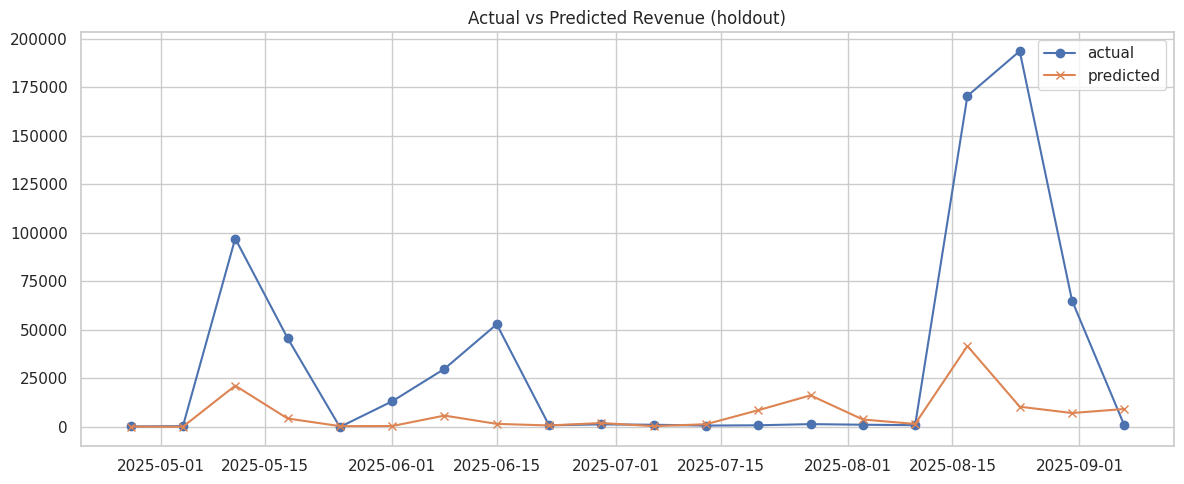

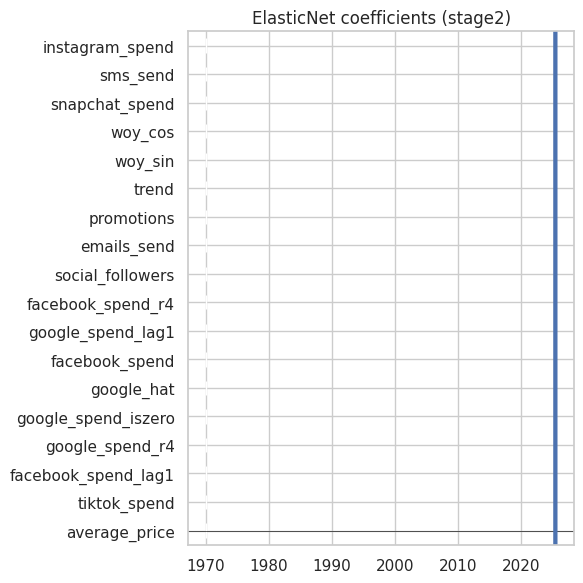

In [23]:
# Diagnostics: actual vs predicted (natural scale)
test = test.copy()
test['pred_revenue'] = np.expm1(y2_pred_test)  # revert log1p
test['actual_revenue'] = np.expm1(y2_test)

plt.figure(figsize=(12,5))
plt.plot(test['week'], test['actual_revenue'], label='actual', marker='o')
plt.plot(test['week'], test['pred_revenue'], label='predicted', marker='x')
plt.title('Actual vs Predicted Revenue (holdout)')
plt.legend()
plt.tight_layout()

# residuals
test['resid'] = test['actual_revenue'] - test['pred_revenue']
plt.figure(figsize=(10,4))
plt.axhline(0, color='k', linewidth=0.5)
plt.plot(test['week'], test['resid'], marker='o')
plt.title('Residuals (actual - predicted) on holdout')
plt.tight_layout()

# feature importance (ElasticNet coefficients)
coefs = pd.Series(pipe2.named_steps['en'].coef_, index=stage2_features)
display(coefs.sort_values().round(4))
coefs.sort_values().plot(kind='barh', figsize=(6,6))
plt.title('ElasticNet coefficients (stage2)')
plt.tight_layout()

,price_factor,promotions,pred_revenue
0,0.9,0,50537.523755
1,0.9,1,50537.523755
2,1.0,0,9277.692975
3,1.0,1,9277.692975
4,1.1,0,1702.534985
5,1.1,1,1702.534985
6,1.2,0,311.762956
7,1.2,1,311.762956


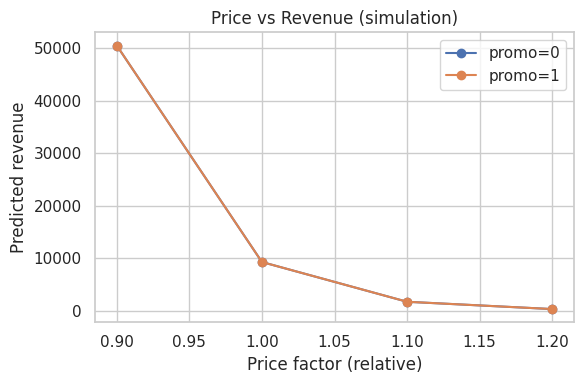

In [24]:
# Sensitivity simulation: change average_price and promotions to see effect on predicted revenue
baseline = test.iloc[-1:].copy()
baseline_vals = baseline[stage2_features].iloc[0].to_dict()

def simulate_price_promo(price_factors=[0.9,1.0,1.1,1.2], promo_values=[0,1]):
    rows = []
    for pf in price_factors:
        for p in promo_values:
            row = baseline_vals.copy()
            row['average_price'] = row.get('average_price', baseline['average_price'].iloc[0]) * pf
            row['promotions'] = p
            X = pd.DataFrame([row])
            X_scaled = X[stage2_features]
            pred_log = pipe2.predict(X_scaled)[0]
            rows.append({'price_factor':pf, 'promotions':p, 'pred_revenue':np.expm1(pred_log)})
    return pd.DataFrame(rows)

sim = simulate_price_promo()
display(sim)
plt.figure(figsize=(6,4))
for p in sim['promotions'].unique():
    s = sim[sim['promotions']==p]
    plt.plot(s['price_factor'], s['pred_revenue'], marker='o', label=f'promo={p}')
plt.xlabel('Price factor (relative)'); plt.ylabel('Predicted revenue'); plt.title('Price vs Revenue (simulation)'); plt.legend(); plt.tight_layout()